In [1]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import matplotlib.pyplot as plt
import os
import datetime
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from captum.influence import TracInCPFast
from torch.utils.data import DataLoader, Dataset, Subset
from pathlib import Path

# Preliminaries

## Convolutional Neural Network Definition

In [3]:
class LogisticRegressionModelTorch(nn.Module):
    def __init__(self, num_classes=10, input_shape=(1,28,28)):
        super(LogisticRegressionModelTorch, self).__init__()
        torch.manual_seed(42)
        self.fc = nn.Linear(np.prod(input_shape), num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Data Loading and 10% Subset

In [4]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

In [6]:
trainset = torchvision.datasets.MNIST(
            root='data', download=True, train=True, transform=normalize
        )
testset = torchvision.datasets.MNIST(
    root='data', download=True, train=False, transform=normalize
)

torch.manual_seed(42)

train_ids = torch.randperm(len(trainset))[:int(len(trainset) * 0.1)]
trainset = Subset(trainset, train_ids)
test_ids = torch.randperm(len(testset))[:int(len(testset) * 0.1)]
testset = Subset(testset, test_ids)

## Training Utils

In [7]:
def train(net, trainset, testset, checkpoints_dir: str):

    train_dataloader = DataLoader(
      trainset,
      batch_size=256,
      shuffle=False,
    )
    test_dataloader = DataLoader(
      testset,
      batch_size=256,
      shuffle=False,
    )

    if checkpoints_dir is not None:
      Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    num_epochs = 5
    save_every = 1

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        running_loss = 0.0

        # Wrap training loop with tqdm for progress visualization
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}", leave=True, position=0)

        for i, data in progress_bar:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / (i + 1))  # Display loss in tqdm

            if (i + 1) % 100 == 0:
                epoch_loss += running_loss
                running_loss = 0.0

        if epoch % save_every == 0 and checkpoints_dir is not None:
            checkpoint_name = f"checkpoint-{epoch}.pt"
            torch.save({
                "epoch": epoch,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": epoch_loss,
            }, os.path.join(checkpoints_dir, checkpoint_name))

        # Calculate validation accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_dataloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Accuracy of the network on test set at epoch {epoch}: {100 * correct / total:.2f}%")

In [9]:
def loss_per_sample(net, data):
  loss = nn.CrossEntropyLoss(reduction='none')
  dataloader = DataLoader(
    data,
    batch_size=len(data),
    shuffle=False,
  )
  losses = None
  with torch.no_grad():
    for batch in dataloader:
      inputs, labels = batch
      outputs = net(inputs)
      losses = loss(outputs, labels)
  return losses.numpy()

# TP Tasks


## Task 1: Model Trainning (Full Dataset)

> Add blockquote



Call the training function by giving the full trainset and testset. Save the checkpoints (model parameters) in the directory "model_full_dataset" using the *checkpoints_dir* argument.

Measure the training time and save it to a variable

In [10]:
model_full = LogisticRegressionModelTorch()

In [11]:
# TODO: Complete the block
import time

model_full = LogisticRegressionModelTorch()
checkpoints_dir = "model_full_dataset"
start_time = time.time()
train(model_full, trainset, testset, checkpoints_dir)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")


Epoch 1: 100%|██████████| 24/24 [00:02<00:00, 11.91it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.40%


Epoch 2: 100%|██████████| 24/24 [00:02<00:00, 10.27it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.40%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 15.90it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.40%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 15.27it/s, loss=0.958]


Accuracy of the network on test set at epoch 3: 82.10%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 15.20it/s, loss=0.849]


Accuracy of the network on test set at epoch 4: 83.50%
Training completed in 10.34 seconds


**Q1.1**: What is the train and test accuracy at the end of the training and the total training time?

TODO: Answer

At the end of the training, the model achieved an accuracy of 83.50% on the test set, demonstrating a good generalization ability on unseen data.

**Q1.2**: Compute the loss of **test** samples using the *loss_per_sample* function. Then plot a histogram of the test losses using matplotlib

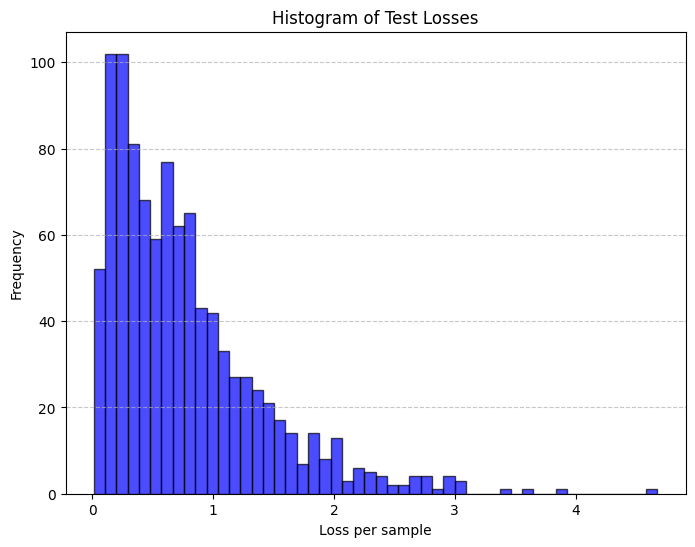

In [14]:
# TODO: Complete the block
import matplotlib.pyplot as plt

test_losses = loss_per_sample(model_full, testset)

plt.figure(figsize=(8, 6))
plt.hist(test_losses, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Loss per sample")
plt.ylabel("Frequency")
plt.title("Histogram of Test Losses")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Q1.2**: Find the **test** sample id with the highest loss. Print its loss value and store its id.

In [15]:
high_loss_test_id = None
# TODO: Complete the block
test_losses = loss_per_sample(model_full, testset)
high_loss_test_id = np.argmax(test_losses)
highest_loss_value = test_losses[high_loss_test_id]

print(f"Test sample ID with highest loss: {high_loss_test_id}")
print(f"Highest loss value: {highest_loss_value:.4f}")


Test sample ID with highest loss: 785
Highest loss value: 4.6784


##Task 2: Leave-One-Out (LOO) Influence

**Q2.1**. Plot the image with the highest test loss (high_loss_test_id).

In [17]:
def plot_img(img, label):
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(f"Label: {label}")
  plt.show()

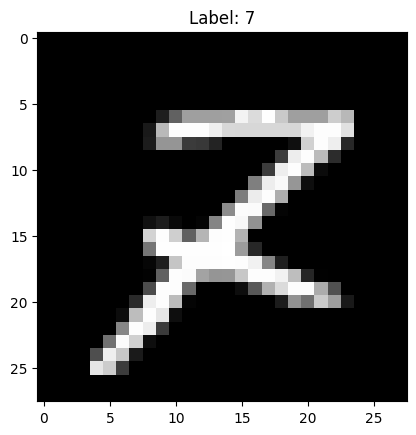

In [19]:
# TODO: Complete the block

high_loss_img, high_loss_label = testset[high_loss_test_id]

plot_img(high_loss_img, high_loss_label)


TODO: Answer

The image shows a handwritten 7, but its slanted shape might confuse the model, leading to misclassification.

**Q2.2**. Exclude the first 10 samples, one sample each time and train the model again. You will train in total 10 models. When you exclude each sample, compute the new loss of the model on the sample sample with the high_loss_test_id. Save the loss on high_loss_test_id to the array loo_losses_array.

Do not save the model weights, call the train function with *checkpoints_dir = None*.

In [21]:
train_enumerated_ids = np.arange(len(trainset))

In [22]:
loo_losses_array = []
for i in range(10):
  current_ids = np.delete(train_enumerated_ids, i)
  print(f'excluding id {i}, Current train ids:', current_ids)
  current_trainset = Subset(trainset, current_ids)
  reduced_model = LogisticRegressionModelTorch()

  # TODO: Complete the block

  train(reduced_model, current_trainset, testset, checkpoints_dir=None)
  test_losses = loss_per_sample(reduced_model, testset)
  loo_losses_array.append(test_losses[high_loss_test_id])

print("LOO Losses on high_loss_test_id:", loo_losses_array)


excluding id 0, Current train ids: [   1    2    3 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 14.63it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.50%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 15.39it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.20%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 13.33it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:02<00:00, 11.47it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.20%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 14.70it/s, loss=0.849]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 1, Current train ids: [   0    2    3 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 15.06it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.20%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 14.67it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.20%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 13.86it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 13.56it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.20%


Epoch 5: 100%|██████████| 24/24 [00:02<00:00, 10.41it/s, loss=0.85]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 2, Current train ids: [   0    1    3 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 14.80it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.40%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 14.71it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.10%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 14.60it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.40%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 14.27it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.20%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 14.21it/s, loss=0.85]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 3, Current train ids: [   0    1    2 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:02<00:00, 10.82it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.30%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 12.85it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.30%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 13.73it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 15.02it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.10%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 15.86it/s, loss=0.849]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 4, Current train ids: [   0    1    2 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 15.51it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.30%


Epoch 2: 100%|██████████| 24/24 [00:02<00:00, 11.14it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.30%


Epoch 3: 100%|██████████| 24/24 [00:02<00:00, 11.67it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 15.02it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.10%


Epoch 5: 100%|██████████| 24/24 [00:02<00:00, 10.50it/s, loss=0.849]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 5, Current train ids: [   0    1    2 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 15.59it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.30%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 15.63it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.30%


Epoch 3: 100%|██████████| 24/24 [00:02<00:00, 10.90it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 14.18it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.10%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s, loss=0.85]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 6, Current train ids: [   0    1    2 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 14.74it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.40%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 15.05it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.10%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 15.02it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 12.30it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.10%


Epoch 5: 100%|██████████| 24/24 [00:02<00:00, 11.98it/s, loss=0.85]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 7, Current train ids: [   0    1    2 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 15.09it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.20%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 14.89it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.30%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 15.18it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 14.94it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.10%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 13.96it/s, loss=0.849]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 8, Current train ids: [   0    1    2 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:02<00:00, 11.11it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.20%


Epoch 2: 100%|██████████| 24/24 [00:01<00:00, 15.70it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.20%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 15.52it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 15.28it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.10%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 15.21it/s, loss=0.85]


Accuracy of the network on test set at epoch 4: 83.50%
excluding id 9, Current train ids: [   0    1    2 ... 5997 5998 5999]


Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 14.85it/s, loss=2.08]


Accuracy of the network on test set at epoch 0: 64.40%


Epoch 2: 100%|██████████| 24/24 [00:02<00:00, 11.52it/s, loss=1.48]


Accuracy of the network on test set at epoch 1: 75.30%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 13.53it/s, loss=1.14]


Accuracy of the network on test set at epoch 2: 79.30%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 12.66it/s, loss=0.959]


Accuracy of the network on test set at epoch 3: 82.00%


Epoch 5: 100%|██████████| 24/24 [00:02<00:00, 11.51it/s, loss=0.849]


Accuracy of the network on test set at epoch 4: 83.50%
LOO Losses on high_loss_test_id: [4.676516, 4.674693, 4.676834, 4.677168, 4.677127, 4.677721, 4.677022, 4.6771636, 4.6768355, 4.6792536]


**Q2.3** Compute the loo losses differences. You need to subtract the loss of high_loss_test_id when then model was trained using the full dataset, from each loo_loss in the loo_losses_array. Concisely,

$L($high_loss_test_id$, \theta_{-z_i}) - L($high_loss_test_id$, \theta), i=[0,...,9]$.

$\theta$ denote the model parameters when trained with all data and $\theta_{-z_i}$ the model parameters when trained without the sample $z_i$.

Store the 10 loss differences in loss_diffs array.

In [24]:
loss_diffs = []
# TODO: Complete the block
full_model_losses = loss_per_sample(model_full, testset)
full_loss_high_id = full_model_losses[high_loss_test_id]

loss_diffs = [loo_loss - full_loss_high_id for loo_loss in loo_losses_array]
print("Loss differences (LOO impact):", loss_diffs)



Loss differences (LOO impact): [-0.0018920898, -0.0037150383, -0.0015740395, -0.0012402534, -0.0012812614, -0.00068712234, -0.0013861656, -0.001244545, -0.001572609, 0.0008454323]


**Q2.4** How many of the loss differences are positive and how many negative? What does negative and positive difference mean?

TODO: Answer

There are 9 negative differences and 1 positive difference. A negative difference means that removing the sample reduced the loss, suggesting that the sample was not helpful or even harmful to the model. A positive difference means that removing the sample increased the loss, indicating that the sample was important for improving the model’s prediction.

## Task 3 Approximating LOO using TracIn Influence Function

In [25]:
def checkpoints_load_func(net, checkpoint_path):
    weights = torch.load(checkpoint_path)
    net.load_state_dict(weights["model_state_dict"])
    return 1.

In [26]:
def get_checkpoint_paths(dir):
  return [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.pt')]

In [27]:
fc_layer = list(model_full.children())[-1]
loss_fn = nn.CrossEntropyLoss()

In [28]:
test_examples_features = torch.stack([testset[i][0] for i in range(len(testset))])
test_examples_true_labels = torch.Tensor([testset[i][1] for i in range(len(testset))]).long()
high_loss_test_sample = (test_examples_features[high_loss_test_id].unsqueeze(0), test_examples_true_labels[high_loss_test_id].unsqueeze(0))

In [29]:
ckpts = get_checkpoint_paths('model_full_dataset')
ckpts

['model_full_dataset/checkpoint-3.pt',
 'model_full_dataset/checkpoint-2.pt',
 'model_full_dataset/checkpoint-0.pt',
 'model_full_dataset/checkpoint-4.pt',
 'model_full_dataset/checkpoint-1.pt']

In [30]:
first_10_train_samples = Subset(trainset, np.arange(10))

In [31]:
tracin_cp= TracInCPFast(
    model=model_full,
    final_fc_layer=fc_layer,
    train_dataset=first_10_train_samples,
    checkpoints=ckpts,
    loss_fn=loss_fn,
    checkpoints_load_func=checkpoints_load_func,
    batch_size=256
)

**Q3.1** Compute the train-to-test influence using TracIn of the first 10 training samples on the high_loss_test_sample (defined above). Save the influence scores in the z_inf_vector variable. Measure the time to compute the influence of the 10 samples and compare it with the time of training the model as computed in Q1.1.

Hint: use with the function *influence* from https://captum.ai/api/influence.html#tracincpfast.

In [37]:
z_inf_vector = None
# TODO: complete the block

start_time = time.time()
z_inf_vector = tracin_cp.influence(high_loss_test_sample)
training_time = time.time() - start_time
print(f"Influence computation completed in {training_time:.2f} seconds")

print(z_inf_vector)

Influence computation completed in 0.10 seconds
tensor([[  64.0665,  995.4119,   27.9608, -324.4008, -140.3208, -313.1388,
          -88.7214, -178.5711,  -52.9988, -672.2537]])


<ipython-input-25-bc86d8c01204>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(checkpoint_path)


TracIn is 500 times faster than full model training, making it a highly efficient alternative to the traditional Leave-One-Out (LOO) approach.

In [36]:
z_inf_vector = z_inf_vector.flatten()

**Q3.2** Plot the scatter plot between the loss_diffs array and the approximated influence z_inf_vector. What do you observe?

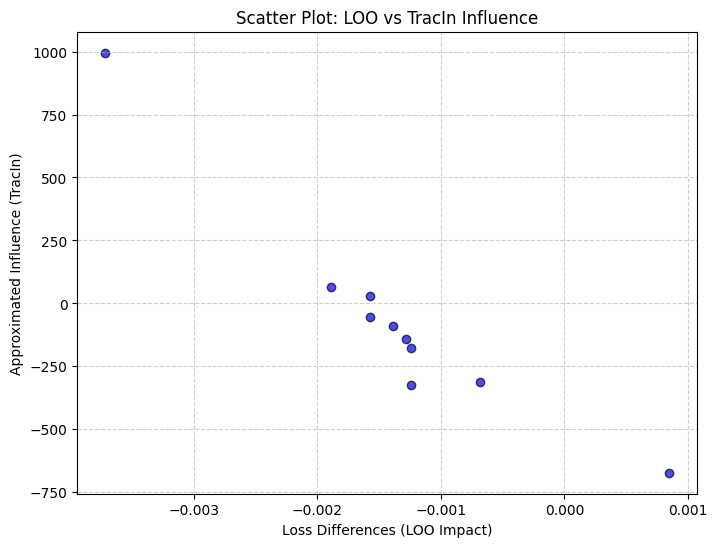

In [38]:
# TODO: Complete the block

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(loss_diffs, z_inf_vector, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Loss Differences (LOO Impact)")
plt.ylabel("Approximated Influence (TracIn)")
plt.title("Scatter Plot: LOO vs TracIn Influence")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()



**Q3.3** Compute the spearman correlation coefficient between the loss_diffs array and the approximated influence z_inf_vector. Are the two vectors correlated?

In [43]:
from scipy.stats import spearmanr
# TODO: Complete the block

loss_diffs = np.array(loss_diffs).flatten()
z_inf_vector = np.array(z_inf_vector).flatten()

spearman_corr, p_value = spearmanr(loss_diffs, z_inf_vector)

print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value}")


Spearman correlation coefficient: -0.9879
P-value: 9.307459988955517e-08


Yes, the two vectors are strongly correlated, but in opposite directions.

**Q3.4** Use again the function *influence* from tracin again but now compute the top-10 proponents (positive influence) and proponents (negative influence) to high_loss_test_sample from all training samples. Store the proponenets/oppenents ids and values in variables.

In [39]:
tracin_cp= TracInCPFast(
    model=model_full,
    final_fc_layer=fc_layer,
    train_dataset=trainset,
    checkpoints=ckpts,
    loss_fn=loss_fn,
    checkpoints_load_func=checkpoints_load_func,
    batch_size=256
)

In [54]:
# TODO: Complete the block

proponents_indices, proponents_influence_scores = tracin_cp.influence(
    high_loss_test_sample, k=10, proponents=True, show_progress=False
)

opponents_indices, opponents_influence_scores = tracin_cp.influence(
    high_loss_test_sample, k=10, proponents=False, show_progress=False
)




<ipython-input-25-bc86d8c01204>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(checkpoint_path)


In [55]:
proponents_indices, proponents_influence_scores

(tensor([[ 672,  445, 4168, 1647, 2261, 2972, 1353, 1810, 5195, 2240]]),
 tensor([[3322.5125, 3311.9751, 3299.5718, 3294.6218, 3147.2295, 3110.1829,
          3096.1572, 3075.3730, 3008.3120, 2996.8530]]))

In [56]:
opponents_indices, opponents_influence_scores

(tensor([[4580, 3932, 1945,  610, 4035, 4764, 4568, 5991, 4013, 5777]]),
 tensor([[-2116.2700, -1785.8566, -1721.2675, -1618.8458, -1579.1450, -1470.5083,
          -1449.5088, -1447.6493, -1442.0149, -1430.5283]]))

###Plotting images

In [57]:
def display_test_example(example, true_label):
    fig, ax = plt.subplots()
    print('true_class:', true_label)
    ax.imshow(example.squeeze())
    plt.show()

def display_training_examples(examples, true_labels, figsize=(10,4)):
    fig = plt.figure(figsize=figsize)
    num_examples = len(examples)
    for i in range(num_examples):
        ax = fig.add_subplot(1, num_examples, i+1)
        ax.imshow(examples[i].squeeze())
        ax.set_title(true_labels[i])
    plt.show()
    return fig

def display_proponents_and_opponents(test_examples_batch, proponents_indices, opponents_indices, test_examples_true_labels):
    for (
        test_example,
        test_example_proponents,
        test_example_opponents,
        test_example_true_label,
    ) in zip(
        test_examples_batch,
        proponents_indices,
        opponents_indices,
        test_examples_true_labels,
    ):

        print("test example:")
        display_test_example(
            test_example,
            test_example_true_label
        )

        print("proponents:")
        test_example_proponents_tensors, test_example_proponents_labels = zip(
            *[trainset[i] for i in test_example_proponents]
        )
        display_training_examples(
            test_example_proponents_tensors, test_example_proponents_labels, figsize=(20, 8)
        )

        print("opponents:")
        test_example_opponents_tensors, test_example_opponents_labels = zip(
            *[trainset[i] for i in test_example_opponents]
        )
        display_training_examples(
            test_example_opponents_tensors, test_example_opponents_labels, figsize=(20, 8)
        )

Call the display_proponents_and_opponents to see the proponents and opponents_indices

test example:
true_class: tensor(7)


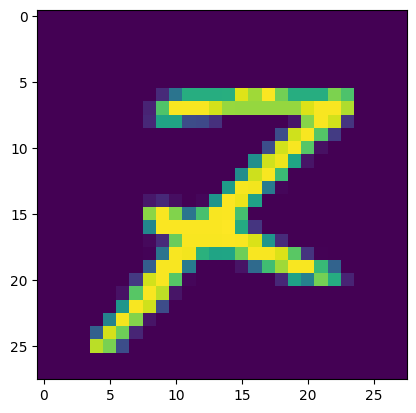

proponents:


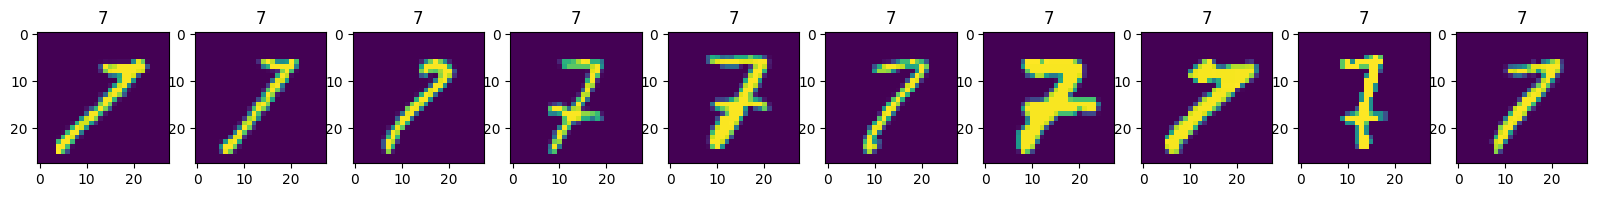

opponents:


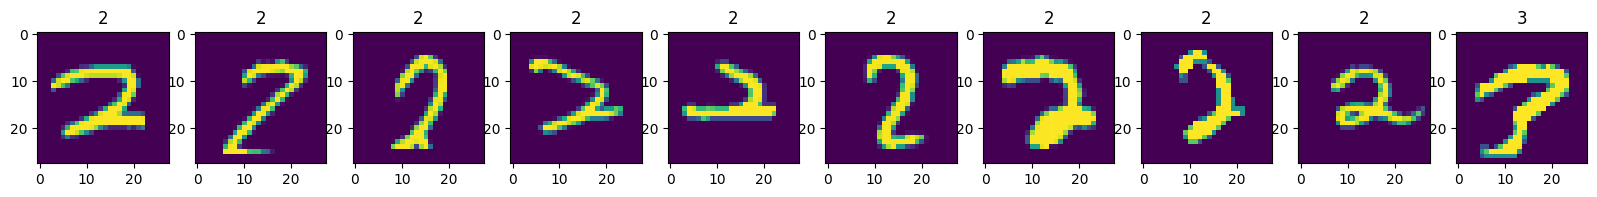

In [58]:
display_proponents_and_opponents(
    high_loss_test_sample[0],
    proponents_indices,
    opponents_indices,
    high_loss_test_sample[1],
    )

**Q3.5** Find the predicted class of the high_loss_test_sample. What is the predicted class? What do you observe in the images above?

Hint: give the model the input features high_loss_test_sample[1] and take the torch.argmax.

In [59]:
# TODO: complete the block

output = model_full(high_loss_test_sample[0])
predicted_class = torch.argmax(output, dim=1).item()


In [60]:
predicted_class

2

###BONUS: Model Manipulation

We select the misclassified sample 384.

Remove the top-**100** from the dataset and train the model again. Do not save the checkpoints (call the train function with checkpoints_dir=None). What happens to the prediction of the sample 384 now?

In [67]:
# TODO: Complete the block
import torch
import numpy as np

test_sample_384 = (test_examples_features[384].unsqueeze(0), test_examples_true_labels[384].unsqueeze(0))


initial_prediction = torch.argmax(model_full(test_sample_384[0])).item()
true_label = test_examples_true_labels[384].item()
print(f"Before retraining -> True Class: {true_label}, Predicted: {initial_prediction}")


influence_scores_all = tracin_cp.influence(test_sample_384, proponents=True, show_progress=False)


influence_scores_all = influence_scores_all.squeeze().numpy()

top_100_indices = np.argsort(-influence_scores_all)[:100]

new_train_indices = [i for i in range(len(trainset)) if i not in top_100_indices]
new_trainset = torch.utils.data.Subset(trainset, new_train_indices)

retrained_model = LogisticRegressionModelTorch()
train(retrained_model, new_trainset, testset, checkpoints_dir=None)

new_prediction = torch.argmax(retrained_model(test_sample_384[0])).item()
print(f"After retraining -> True Class: {true_label}, New Predicted: {new_prediction}")





Before retraining -> True Class: 5, Predicted: 3


<ipython-input-25-bc86d8c01204>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(checkpoint_path)
Epoch 1: 100%|██████████| 24/24 [00:01<00:00, 13.87it/

Accuracy of the network on test set at epoch 0: 64.30%


Epoch 2: 100%|██████████| 24/24 [00:02<00:00,  8.69it/s, loss=1.46]


Accuracy of the network on test set at epoch 1: 74.40%


Epoch 3: 100%|██████████| 24/24 [00:01<00:00, 13.15it/s, loss=1.11]


Accuracy of the network on test set at epoch 2: 78.20%


Epoch 4: 100%|██████████| 24/24 [00:01<00:00, 14.33it/s, loss=0.937]


Accuracy of the network on test set at epoch 3: 81.00%


Epoch 5: 100%|██████████| 24/24 [00:01<00:00, 14.78it/s, loss=0.829]


Accuracy of the network on test set at epoch 4: 81.90%
After retraining -> True Class: 5, New Predicted: 3
